*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

Help found at:
- StackOverflow (where else?!)
- https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_KNN.ipynb: helped me a lot with the graphs and initial investigation
- https://miteyd.github.io/book-recommendation-engine-using-knn/: helped me with getting the data scaled down as I was having 10k users left (as I was thinking there was too little data when working with 1k users).


In [271]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [272]:
# get data files
books_filename = 'data/BX-Books.csv'
ratings_filename = 'data/BX-Book-Ratings.csv'

In [273]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'int32'})

## Cleaning data

In [274]:
# User has more than 100 ratings
user_cnt = df_ratings.groupby('user')['rating'].count().reset_index().rename(columns = {'rating': 'user_count'})
book_cnt = df_ratings.groupby('isbn')['rating'].count().reset_index().rename(columns = {'rating': 'book_count'})

df_ratings_2 = df_ratings.copy()
df_ratings_2 = df_ratings_2.merge(user_cnt, on='user')
df_ratings_2 = df_ratings_2.merge(book_cnt, on='isbn')

df_ratings_2 = df_ratings_2.loc[(df_ratings_2.user_count >= 200) & (df_ratings_2.book_count >= 100)]
df_ratings_2

,user,isbn,rating,user_count,book_count
63,278418,0446520802,0,4533,116
65,3363,0446520802,0,901,116
66,7158,0446520802,10,400,116
69,11676,0446520802,10,13602,116
74,23768,0446520802,6,1708,116
...,...,...,...,...,...
550455,252071,0312971125,0,424,111
550457,258185,0312971125,0,758,111
550458,263877,0312971125,0,444,111
550459,265115,0312971125,10,1221,111


In [275]:
books_with_ratings = pd.merge(df_ratings_2, df_books, on='isbn')
books_with_ratings

,user,isbn,rating,user_count,book_count,title,author
0,278418,0446520802,0,4533,116,The Notebook,Nicholas Sparks
1,3363,0446520802,0,901,116,The Notebook,Nicholas Sparks
2,7158,0446520802,10,400,116,The Notebook,Nicholas Sparks
3,11676,0446520802,10,13602,116,The Notebook,Nicholas Sparks
4,23768,0446520802,6,1708,116,The Notebook,Nicholas Sparks
...,...,...,...,...,...,...,...
49512,252071,0312971125,0,424,111,Crazy for You,Jennifer Crusie
49513,258185,0312971125,0,758,111,Crazy for You,Jennifer Crusie
49514,263877,0312971125,0,444,111,Crazy for You,Jennifer Crusie
49515,265115,0312971125,10,1221,111,Crazy for You,Jennifer Crusie


In [276]:
df_ratings_cnt_tmp = books_with_ratings.groupby('rating').size()
df_ratings_cnt_tmp.name='count'
df_ratings_cnt_tmp

rating
0     36969
1        46
2        48
3       106
4       169
5      1026
6       810
7      1933
8      3110
9      2558
10     2742
Name: count, dtype: int64

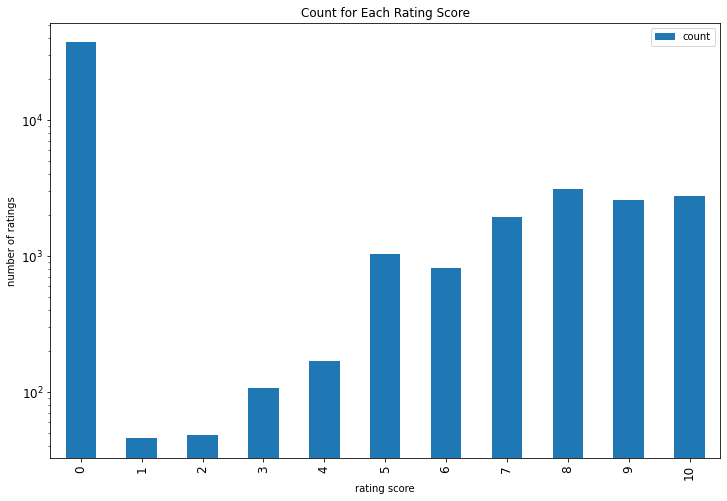

In [277]:
ax = df_ratings_cnt_tmp.reset_index().rename(columns={'index': 'rating'}).plot(
    x='rating',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("rating score")
ax.set_ylabel("number of ratings");

## Training

In [278]:
books_with_ratings_2 = books_with_ratings.drop_duplicates(['title', 'user'])

user_mat = books_with_ratings_2.pivot(values='rating', index='title', columns='user').fillna(0)
user_mat

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Without Remorse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [279]:
user_mat_sparse = csr_matrix(user_mat.values)

In [280]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='auto')

# fit
model_knn.fit(user_mat_sparse)

NearestNeighbors(metric='cosine')

In [281]:
TEST_TITLE = "The Queen of the Damned (Vampire Chronicles (Paperback))"

In [282]:
X = user_mat[user_mat.index == TEST_TITLE]
X.to_numpy().reshape(-1, 1)

distances, indices = model_knn.kneighbors(X, n_neighbors=6)

## Recommendations!

In [283]:
raw_recommends = sorted(zip(indices.squeeze().tolist(), distances.squeeze().tolist()), key=lambda x: x[1])[::-1]
raw_recommends

[(100, 0.7939835419270879),
 (617, 0.7448657003312193),
 (251, 0.7345068863988313),
 (599, 0.5376338446489461),
 (610, 0.5178411864186413),
 (567, 2.220446049250313e-16)]

In [284]:
{
    user_mat.index[idx]: dist
    for idx, dist in raw_recommends
}

{'Catch 22': 0.7939835419270879,
 'The Witching Hour (Lives of the Mayfair Witches)': 0.7448657003312193,
 'Interview with the Vampire': 0.7345068863988313,
 'The Tale of the Body Thief (Vampire Chronicles (Paperback))': 0.5376338446489461,
 'The Vampire Lestat (Vampire Chronicles, Book II)': 0.5178411864186413,
 'The Queen of the Damned (Vampire Chronicles (Paperback))': 2.220446049250313e-16}

In [285]:
# function to return recommended books - this will be tested
def get_recommends(book = "", recommendations=5):
    X = user_mat[user_mat.index == book]
    X.to_numpy().reshape(-1, 1)

    distances, indices = model_knn.kneighbors(X, n_neighbors=recommendations+1)

    raw_recommends = sorted(zip(indices.squeeze().tolist(), distances.squeeze().tolist()), key=lambda x: x[1])[::-1]

    return_value = [
        book,
        []
    ]
    
    for idx, dist in raw_recommends[:recommendations]:
        return_value[1].append(
            (user_mat.index[idx], dist)
        )
    
    return return_value

## Testing

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [286]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
    test_pass = True
    recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
    if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
        test_pass = False
    recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
    recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
    for i in range(2): 
        if recommends[1][i][0] not in recommended_books:
            test_pass = False
        if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
            test_pass = False

    if test_pass:
        print("You passed the challenge! 🎉🎉🎉🎉🎉")
    else:
        print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [("I'll Be Seeing You", 0.8016210581447822), ('The Weight of Water', 0.7708583572697412), ('The Surgeon', 0.7699410973804288), ('I Know This Much Is True', 0.7677075092617776), ('The Lovely Bones: A Novel', 0.7234864549790632)]]
You passed the challenge! 🎉🎉🎉🎉🎉
